countries (Shapefile)<br>
regions (CSV)<br>
places (CSV)

In [ ]:
import geopandas as gpd
import glob
import pandas as pd
import folium




# countries

# Pfad zu den Shapefiles (z.B. alle .shp-Dateien in einem Verzeichnis)
shapefile_path = "C:/Users/alexa/Documents/Webapp/GPC-BNDR-ADM-HPR-SAMPLE-WO-SELECTED_SHP/*.shp"

# Lade alle Shapefiles und kombiniere sie in ein GeoDataFrame
gdf_list = []
for shp in glob.glob(shapefile_path):
    gdf = gpd.read_file(shp)
    gdf_list.append(gdf)

# Kombiniere alle GeoDataFrames
all_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

#folium.GeoJson(all_gdf).add_to(map)




regions = pd.read_csv("C:/Users/alexa/Documents/Webapp/GPC-POST-GEO-SAMPLE-WO-SELECTED/CSV/GPC-REGIONS-GEO-SAMPLE-WO-SELECTED.csv", sep=';')

for index, row in regions.iterrows():
    # Erstelle eine Liste von Koordinaten aus den Spalten 'longitude' und 'latitude'
    coordinates = [(row['latitude'], row['longitude'])]  # Hier wird die Liste mit einem Tuple von Longitude und Latitude erstellt

    # Erstelle ein Polygon
    folium.Polygon(
        locations=coordinates,
        color='blue',  # Farbe des Polygons
        fill=True,
        fill_color='blue',  # Füllfarbe
        fill_opacity=0.6,
        popup=row['region1']  # Name oder weitere Informationen zur Region
    ).add_to(map)



places = pd.read_csv("C:/Users/alexa/Documents/Webapp/GPC-POST-GEO-SAMPLE-WO-SELECTED/CSV/GPC-PLACES-GEO-SAMPLE-WO-SELECTED.csv", sep=';')

for index, row in places.iterrows():
    # Erstelle eine Liste von Koordinaten aus den Spalten 'longitude' und 'latitude'
    coordinates = [(row['latitude'], row['longitude'])]  # Hier wird die Liste mit einem Tuple von Longitude und Latitude erstellt

    # Erstelle ein Polygon
    folium.Polygon(
        locations=coordinates,
        color='blue',  # Farbe des Polygons
        fill=True,
        fill_color='blue',  # Füllfarbe
        fill_opacity=0.6,
        popup=row['postcode']  # Name oder weitere Informationen zur Region
    ).add_to(map)




#Creates a map with Mapbox; without tiles and API_key specifiers, a map with OpenStreetMap is created
map = folium.Map(
    location=[52.52, 13.40],
    zoom_start=6,
    tiles=f'https://api.mapbox.com/styles/v1/mapbox/streets-v11/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1IjoiZWwtZ2lmIiwiYSI6ImNtMXQyYWdsYzAwMGUycXFzdmY2eDFnaWMifQ.yirQoMK5TCdmZZUFUNXxwA',
    attr='Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="https://www.mapbox.com/">Mapbox</a>'
)

folium.GeoJson(r"C:\Users\alexa\Documents\Webapp\geonames-postal-code@public.geojson").add_to(map)

for i, lat in enumerate(ds['latitude'].values[::10]):
    for j, lon in enumerate(ds['longitude'].values[::10]):
        speed = wind_speed[i, j]  # Windgeschwindigkeit an der Position (i, j)
        folium.Marker(
            [lat, lon], 
            popup=f"Windgeschwindigkeit: {speed:.2f} m/s"
        ).add_to(map)

map.save("map.html")

postal codes (OpenDataSoft)

In [ ]:
import requests
import geopandas as gpd
import folium

# API URL and parameters
base_api_url = "https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-postal-code@public/records"
limit = 20 # API pagination
total_count = 999999  # Total number of records expected
all_geojson_data = []  # List to store all geojson data

# Fetch all pages of data
for offset in range(0, total_count, limit):
    api_url = f"{base_api_url}?limit={limit}&offset={offset}"
    
    # Send API request
    response = requests.get(api_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Extract the data in JSON format
        data = response.json()
        
        # Check if 'results' exists in the data
        if 'results' in data:
            # Extract GeoJSON data from JSON
            geojson_data = data['results']
            all_geojson_data.extend(geojson_data)  # Add the current results
        else:
            print("Key 'results' not found in the data.")
            break  # End loop if no results are found
    else:
        print(f"Request failed with status code: {response.status_code}, offset: {offset}")
        break  # End loop if an error occurs

# Convert GeoJSON data to a GeoDataFrame
features = [
    feature['geo_shape'] for feature in all_geojson_data if 'geo_shape' in feature
]

# Create the GeoDataFrame and set the CRS
gdf2 = gpd.GeoDataFrame.from_features(features)
gdf2.set_geometry('coordinates', inplace=True)  # Set 'coordinates' column as geometry
gdf2.set_crs(epsg=4326, inplace=True)  # Set CRS to EPSG:4326





# Erstelle eine Folium-Karte
m = folium.Map(location=[20, 0], zoom_start=2)  # Setze den Mittelpunkt und den Zoom der Karte

# Füge die GeoDataFrame-Daten zur Karte hinzu
GeoJson(gdf2).add_to(m)


# Speichere die Karte als HTML-Datei oder zeige sie an
m.save('world_boundaries_map.html')


Country Boundaries (OpenDataSoft)<br>
WPP (HeatMap and MarkerCluster) (OpenStreetMap)

In [ ]:
import requests
import geopandas as gpd
import folium
from folium import GeoJson
from folium.plugins import HeatMap, MarkerCluster



# API URL und Parameter für die Ländergrenzen
base_api_url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/records"
limit = 20  # API-Paginierung
total_count = 256  # Gesamtzahl der erwarteten Datensätze
all_geojson_data = []  # Liste zur Speicherung aller GeoJSON-Daten

# Fetch all pages of data
for offset in range(0, total_count, limit):
    api_url = f"{base_api_url}?limit={limit}&offset={offset}"
    
    # API Anfrage senden
    response = requests.get(api_url)

    # Überprüfen, ob die Anfrage erfolgreich war
    if response.status_code == 200:
        # Die Daten im JSON-Format extrahieren
        boundary_data = response.json()
        
        # Überprüfen, ob 'results' in den Daten vorhanden ist
        if 'results' in boundary_data:
            # GeoJSON-Daten aus dem JSON extrahieren
            geojson_data = boundary_data['results']
            all_geojson_data.extend(geojson_data)  # Füge die aktuellen Ergebnisse hinzu
        else:
            print("Key 'results' nicht in den Daten gefunden.")
            break  # Beende die Schleife, wenn keine Ergebnisse gefunden werden
    else:
        print(f"Fehler bei der Anfrage: {response.status_code}")
        break  # Beende die Schleife, wenn ein Fehler auftritt

# Konvertieren der GeoJSON-Daten in ein GeoDataFrame
features = []
for feature in all_geojson_data:
    if 'geo_shape' in feature:
        geom = feature['geo_shape']['geometry']  # Behalte die Geometrie
        properties = {
            'name': feature.get('name', None)  # Füge den Namen hinzu
        }
        features.append({
            'geometry': geom,
            'properties': properties
        })

# Erstelle das GeoDataFrame und setze das CRS
gdf1 = gpd.GeoDataFrame.from_features(features)
gdf1.set_crs(epsg=4326, inplace=True)  # Setze das CRS auf EPSG:4326




# Windkraftanlagen-Daten abrufen
url = "https://overpass-api.de/api/interpreter?data=[out:json][timeout:99999];node['power'='generator']['generator:source'='wind'](49,9,50,10);out body;" # Europe: (34.8,-30,71.6,60)
response = requests.get(url)

if response.status_code == 200:
    wind_data = response.json()
else:
    print("Fehler beim Abrufen der Windkraftdaten:", response.status_code)
    wind_data = None

# Karte erstellen
m = folium.Map(location=[50.68, 6.72], zoom_start=12)  # Erftstadt-Mitte

# Markercluster-Layer erstellen
marker_layer = folium.FeatureGroup(name="Marker Cluster")
marker_cluster = MarkerCluster().add_to(marker_layer)

# Heatmap-Layer erstellen
heatmap_layer = folium.FeatureGroup(name="Heatmap")

# Kapazitäten nach Land summieren
if wind_data:
    # Initialisiere ein Dictionary zur Speicherung der Kapazitäten nach Ländern
    capacities_by_country = {name: 0 for name in gdf1['name']}  # Verwende die Namen aus gdf1
    heat_data = []
    
    for element in wind_data["elements"]:
        try:
            # Extrahiere die Kapazität aus den tags
            if 'generator:output:electricity' in element['tags']:
                capacity_value = element['tags']['generator:output:electricity']
                # Prüfen und umrechnen je nach Einheit
                if 'kW' in capacity_value:
                    capacity = float(capacity_value.replace('kW', '').strip())
                elif 'MW' in capacity_value:
                    capacity = float(capacity_value.replace('MW', '').strip()) * 1000  # Umrechnung in kW
                elif capacity_value.lower() == 'yes':
                    capacity = 0  # Wenn keine Kapazität angegeben ist
                else:
                    capacity = float(capacity_value)  # Konvertiere direkt zu float, falls keine Einheit
            else:
                capacity = 0  # Wenn keine Kapazität angegeben ist

        except ValueError:
            capacity = 0  # Fehler beim Konvertieren

        # Überprüfen, in welchem Land sich die Windkraftanlage befindet
        point = gpd.points_from_xy([element['lon']], [element['lat']])
        for idx, country in gdf1.iterrows():
            if country['geometry'].contains(point[0]):
                capacities_by_country[country['name']] += capacity

        # Daten zur Heatmap hinzufügen
        heat_data.append([element["lat"], element["lon"], capacity])

        # Marker mit Tooltip zur Markergruppe hinzufügen
        folium.Marker(
            location=[element['lat'], element['lon']],
            tooltip=(
                f'Kapazität: {capacity} kW\n'
                f'Baujahr: {element["tags"].get("construction", "n/a")}\n'
                f'Betreiber: {element["tags"].get("operator", "n/a")}\n'
                f'Hub height: {element["tags"].get("height:hub", "n/a")} m\n'
                f'Rotor diameter: {element["tags"].get("rotor:diameter", "n/a")} m\n'
            )
        ).add_to(marker_cluster)

    # Heatmap zum Heatmap-Layer hinzufügen
    HeatMap(data=heat_data, radius=15, max_zoom=13).add_to(heatmap_layer)

    # Heatmap und Marker-Layer zur Karte hinzufügen
    heatmap_layer.add_to(m)
    marker_layer.add_to(m)

    # Füge die Ländergrenzen zur Karte hinzu
    GeoJson(gdf1.geometry).add_to(m)

    folium.Choropleth(
        geo_data=gdf1,
        name='choropleth',
        data=capacities_by_country,  # Dein Dictionary mit den Kapazitäten
        columns=['name', 'capacity'],  # Hier muss "capacity" vorhanden sein
        key_on='feature.properties.name',  # Schlüssel zur Zuordnung der Länder
        fill_color='YlGn',  # Farbskala
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Windkraftkapazität (kW)'
    ).add_to(m)

    # Füge Layer Controls hinzu
    folium.LayerControl().add_to(m)

    # Karte speichern (optional)
    m.save("wind_energy.html") # just for own visualisation, not used by app.py

    # Überprüfen, ob Features vorhanden sind
    print(f"{len(wind_data['elements'])} Windkraftdaten erfolgreich zur Karte hinzugefügt")
else:
    print("Keine Windkraftdaten verfügbar.")


In [6]:
import requests
from ipyleaflet import Map, Marker, MarkerCluster
from ipywidgets import Layout

# Define the URL for Overpass API query
url = "https://overpass-api.de/api/interpreter?data=[out:json][timeout:99999];node['power'='generator']['generator:source'='solar'](49,9,50,10);out body;"

# Fetch data from Overpass API
response = requests.get(url)
data = response.json()

# Extract relevant data: latitude, longitude, and name (if available)
locations = []
for element in data['elements']:
    lat = element.get('lat')
    lon = element.get('lon')
    name = element.get('tags', {}).get('name', 'PV Generator')
    locations.append((lat, lon, name))

# Initialize the map centered on the area of interest
m = Map(center=(49.5, 9.5), zoom=10, layout=Layout(width='100%', height='600px'))

# Create markers and add them to a MarkerCluster
markers = [Marker(location=(lat, lon), title=name) for lat, lon, name in locations]
marker_cluster = MarkerCluster(markers=markers)

# Add the MarkerCluster to the map
m.add_layer(marker_cluster)

# Display the map
m


Map(center=[49.5, 9.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [ ]:
import requests
import pandas as pd

# Windkraftanlagen-Daten abrufen
url = "https://overpass-api.de/api/interpreter?data=[out:json][timeout:180];node['power'='generator']['generator:source'='solar'](40,9,50,10);out body;"
response = requests.get(url)

# Überprüfen, ob die Anfrage erfolgreich war und die Daten enthalten
if response.status_code == 200:
    wind_data = response.json().get('elements', [])
    
    # DataFrame erstellen
    df = pd.DataFrame(wind_data)

    # Tags in eigene Spalten erweitern
    tags_df = pd.json_normalize(df['tags'])
    
    # Die Tags-Spalten mit dem ursprünglichen DataFrame zusammenführen und einen Suffix für überlappende Spalten verwenden
    df = df.drop(columns=['tags']).join(tags_df, rsuffix='_tag')

    # Die ersten Zeilen anzeigen
        # Alle Spalten anzeigen
    pd.set_option('display.max_columns', None)

    # Die ersten Zeilen des DataFrames anzeigen
    display(df.head())

    df.to_excel("Solaranlagen_Daten.xlsx", index=False)
    print("Die Tabelle wurde erfolgreich als 'Solaranlagen_Daten.xlsx' gespeichert.")
else:
    print("Fehler beim Abrufen der Solarkraftdaten:", response.status_code)


,type,id,lat,lon,description,generator:method,generator:output:electricity,generator:source,generator:type,power,location,note,generator:output:hot_water,name,generator:place,operator,source,generator:location,survey:date,building,layer,generator:output:electricity:energy,diameter,source:width,generator:orientation,wheelchair,amenity,bicycle,fee,motorcar,socket:schuko,start_date,video,generator:output:heat,addr:street,opening_hours,website,frequency,voltage,generator:plant,denotation,leaf_type,natural,operator:wikidata,fixme,generator:solar:modules,bench,lit,lockable,socket:device:USB-A,socket:device:qi-wireless,colour,direction,generator:solar:tracking
0,node,701629811,48.663324,9.203941,Solarzellen auf dem Dach der Lagerhalle,photovoltaic,yes,solar,solar_photovoltaic_panel,generator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,994865515,49.649236,9.272201,Mover,photovoltaic,NaN,solar,solar_photovoltaic_panel,generator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,1041095988,49.649142,9.273090,Mover,photovoltaic,NaN,solar,solar_photovoltaic_panel,generator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,1041095995,49.649298,9.271608,Mover,photovoltaic,NaN,solar,solar_photovoltaic_panel,generator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,1041096004,49.649329,9.271312,Mover,photovoltaic,NaN,solar,solar_photovoltaic_panel,generator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Die Tabelle wurde erfolgreich als 'Windkraftanlagen_Daten.xlsx' gespeichert.


Country Boundaries (OpenStreetMap)<br>
WPP (HeatMap and MarkerCluster) (OpenStreetMap)


In [ ]:
import requests
import geopandas as gpd
from ipyleaflet import Map, Marker, MarkerCluster, GeoJSON, Heatmap

# Funktion zum Abrufen von Windkraftanlagen
def fetch_wind_data():
    wind_url = "https://overpass-api.de/api/interpreter?data=[out:json][timeout:99999];node['power'='generator']['generator:source'='wind'](49,9,50,10);out body;"
    response = requests.get(wind_url)

    if response.status_code == 200:
        wind_data = response.json()
        return wind_data['elements']
    else:
        print(f"Fehler beim Abrufen der Winddaten: {response.status_code}")
        return []

# Funktion zum Abrufen von Ländergrenzen
def fetch_country_data():
    country_url = "https://overpass-api.de/api/interpreter?data=[out:json];relation['boundary'='administrative']['admin_level'='2'];out body;"
    response = requests.get(country_url)

    if response.status_code == 200:
        country_data = response.json()
        return country_data['elements']
    else:
        print(f"Fehler beim Abrufen der Länderdaten: {response.status_code}")
        return []

# Abrufen der Daten
wind_data = fetch_wind_data()
country_data = fetch_country_data()

# Überprüfen, ob die Länderdaten abgerufen wurden
print(f"Anzahl der Länder: {len(country_data)}")

# Erstelle ein GeoDataFrame für die Länder
country_features = []
print(country_data)
for element in country_data:
    for member in element['members']:
        way_id = member['ref']
        way_url = f"https://overpass-api.de/api/interpreter?data=[out:json];way({way_id});out geom;"
        way_response = requests.get(way_url)
        if way_response.status_code == 200:
            way_data = way_response.json()
            for way in way_data['elements']:
                name = element['tags'].get('name', 'Unbekannt')
                country_features.append({'geometry': way['geometry'], 'properties': name})
                print(f'{name} appended')

# Erstelle ein GeoDataFrame und setze die Geometrie manuell
gdf_countries = gpd.GeoDataFrame(country_features)
gdf_countries.set_geometry('geometry', inplace=True)  # Setze die Geometriespalte
gdf_countries.set_crs(epsg=4326, inplace=True)  # Setze das CRS auf EPSG:4326

# Erstelle die ipyleaflet-Karte
m = Map(center=(50, 9.5), zoom=6)

# Füge die Ländergrenzen hinzu, wenn gdf_countries nicht leer ist
if not gdf_countries.empty:
    geojson_countries = GeoJSON(data=gdf_countries.__geo_interface__, style={'color': 'blue', 'weight': 2})
    m.add_layer(geojson_countries)

# MarkerCluster für Windkraftanlagen
marker_cluster = MarkerCluster(name="Windkraftanlagen").add_to(m)
heatmap_data = []  # Daten für die Heatmap

# Füge Windkraftanlagen als Marker hinzu und bereite die Heatmap-Daten vor
for element in wind_data:
    if 'lat' in element and 'lon' in element:
        lat = element['lat']
        lon = element['lon']
        capacity = element['tags'].get('generator:output:electricity', 'N/A')
        
        # Marker hinzufügen
        marker = Marker(location=(lat, lon), title=f'Kapazität: {capacity}')
        marker_cluster.add_child(marker)
        
        # Heatmap-Daten hinzufügen (Kapazität als Gewicht)
        heatmap_data.append([lat, lon, float(capacity.replace('kW', '').strip()) if 'kW' in capacity else 0])

# Füge die Heatmap hinzu
if heatmap_data:
    heatmap_layer = Heatmap(heatmap_data, radius=15, max_zoom=13)
    m.add_layer(heatmap_layer)

# Zeige die Karte an
m


Velocity works with viridis colormap<br>
ColormapControl works only outside Shiny environment (?)

In [4]:
# Notwendige Bibliotheken importieren
from ipyleaflet import Map, ColormapControl
from ipyleaflet.velocity import Velocity
from branca.colormap import linear
import numpy as np
from ipywidgets import Layout

# Beispielhafte Windgeschwindigkeitsdaten generieren
lats = np.linspace(35, 60, 10)  # Breitengrade
lons = np.linspace(-10, 30, 10)  # Längengrade
u = np.random.uniform(-10, 10, (len(lats), len(lons)))  # Zonalgeschwindigkeit
v = np.random.uniform(-10, 10, (len(lats), len(lons)))  # Meridionalgeschwindigkeit

# Berechne die Windgeschwindigkeit (Betrag der Geschwindigkeit)
wind_speed = np.sqrt(u**2 + v**2)

# Erstelle die Velocity Layer
velocity_layer = Velocity(
    data={
        'u': (['lat', 'lon'], u),
        'v': (['lat', 'lon'], v),
        'lat': lats,
        'lon': lons,
    },
    zonal_speed='u',
    meridional_speed='v',
    latitude_dimension='lat',
    longitude_dimension='lon',
    velocity_scale=0.01,
    max_velocity=20,
    display_options={
        'velocityType': 'Wind Speed',
        'displayPosition': 'bottomleft',
        'displayEmptyString': 'No wind data'
    }
)

# Karte erstellen
m = Map(center=[50, 10], zoom=4, layout=Layout(width='100%', height='500px'))

# Velocity Layer zur Karte hinzufügen
m.add_layer(velocity_layer)

# Colormap für Windgeschwindigkeiten basierend auf dem Betrag der Windgeschwindigkeit erstellen
min_wind_speed = wind_speed.min()  # minimale Windgeschwindigkeit
max_wind_speed = wind_speed.max()  # maximale Windgeschwindigkeit

# Eine Farbskala basierend auf dem Betrag der Windgeschwindigkeit
colormap = linear.viridis.scale(min_wind_speed, max_wind_speed)

# ColormapControl zur Karte hinzufügen
colormap_control = ColormapControl(
    caption='Windgeschwindigkeit (m/s)',
    colormap=colormap,
    value_min=min_wind_speed,
    value_max=max_wind_speed,
    position='bottomright'
)

m.add_control(colormap_control)

# Karte anzeigen
m


Map(center=[50, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [3]:
import requests

url = "https://overpass-api.de/api/interpreter?data=[out:json][timeout:99999];node['power'='generator']['generator:source'='wind'](49,9,50,10);out body;"

# Anfrage an die Overpass API senden
response = requests.get(url)
data = response.json()

# Zähler und Summen für Windkraftanlagen mit und ohne Modell
count_with_model = 0
count_without_model = 0
total_capacity_with_model = 0.0
total_capacity_without_model = 0.0

# Funktion zur Umrechnung der Kapazität in MW
def convert_to_mw(value):
    if " MW" in value:
        return float(value.replace(" MW", ""))
    elif " GW" in value:
        return float(value.replace(" GW", "")) * 1000
    elif " kW" in value:
        return float(value.replace(" kW", "")) / 1000
    elif " W" in value:
        return float(value.replace(" W", "")) / 1_000_000
    elif value.isdigit():  # Falls keine Einheit angegeben ist
        return float(value) / 1_000_000
    else:
        return None  # Falls die Umrechnung fehlschlägt

# Modelle und Kapazitäten der Windkraftanlagen ausgeben, wenn vorhanden
for element in data['elements']:  # Die ersten 20 Elemente auswählen
    tags = element['tags']
    model = tags.get('model')
    capacity_raw = tags.get('generator:output:electricity')

    # Kapazität umwandeln in MW, wenn vorhanden und umrechenbar
    capacity = convert_to_mw(capacity_raw) if capacity_raw else None
    
    # Windkraftanlagen mit Modell
    if model:
        print(f"Windkraftanlage Modell: {model}, Kapazität: {capacity} MW\n")
        count_with_model += 1
        if capacity:
            total_capacity_with_model += capacity
    # Windkraftanlagen ohne Modell
    else:
        count_without_model += 1
        if capacity:
            total_capacity_without_model += capacity

# Durchschnittskapazitäten berechnen
avg_capacity_with_model = total_capacity_with_model / count_with_model if count_with_model > 0 else 0
avg_capacity_without_model = total_capacity_without_model / count_without_model if count_without_model > 0 else 0

# Gesamtzahl und Durchschnittskapazität ausgeben
print(f"Anzahl der Windkraftanlagen mit Modell: {count_with_model}")
print(f"Durchschnittliche Kapazität der Windkraftanlagen mit Modell: {avg_capacity_with_model:.2f} MW")
print(f"Anzahl der Windkraftanlagen ohne Modell: {count_without_model}")
print(f"Durchschnittliche Kapazität der Windkraftanlagen ohne Modell: {avg_capacity_without_model:.2f} MW")


Windkraftanlage Modell: N82/1500, Kapazität: 1.5 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: V90/2.0MW, Kapazität: 2.0 MW

Windkraftanlage Modell: V90/2.0MW, Kapazität: 2.0 MW

Windkraftanlage Modell: V80, Kapazität: 2.0 MW

Windkraftanlage Modell: NM82, Kapazität: 1.5 MW

Windkraftanlage Modell: V112/3.0MW, Kapazität: 3.0 MW

Windkraftanlage Modell: MD77, Kapazität: 1.5 MW

Windkraftanlage Modell: MD77, Kapazität: 1.5 MW

Windkraftanlage Modell: MD77, Kapazität: 1.5 MW

Windkraftanlage Modell: MD77, Kapazität: 1.5 MW

Windkraftanlage Modell: MD77, Kapazität: 1.5 MW

Windkraftanlage Modell: Nordex SE N117, Kapazität: 2.4 MW


In [ ]:
import pandas as pd

# Pfad zur Datei
file_path = r"time_series\2015_01_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv"

# Laden der CSV-Datei (tab-separiert)
df = pd.read_csv(file_path, sep='\t')

# Filtern der Zeilen, die 'GenerationUnitType' entweder 'Wind Onshore' oder 'Wind Offshore' enthalten
df_filtered = df[(df['GenerationUnitType'] == 'Wind Onshore ') | (df['GenerationUnitType'] == 'Wind Offshore ')]

# Auswählen der gewünschten Spalten
df_selected = df_filtered[['DateTime (UTC)', 'GenerationUnitCode', 'ActualGenerationOutput(MW)', 'GenerationUnitInstalledCapacity(MW)']]

# Speichern des gefilterten DataFrames in einer Excel-Datei
output_file_path = r"time_series\Filtered_Wind_Data_2015_01.xlsx"
df_selected.to_excel(output_file_path, index=False)

print("Die gefilterten Daten wurden erfolgreich in", output_file_path, "gespeichert.")


<h1> Figures for Thesis

Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_01_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_02_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_03_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_04_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_05_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_06_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_07_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei: E:\MA_data\raw production history ENTSO-E\2015_08_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Bearbeite Datei:

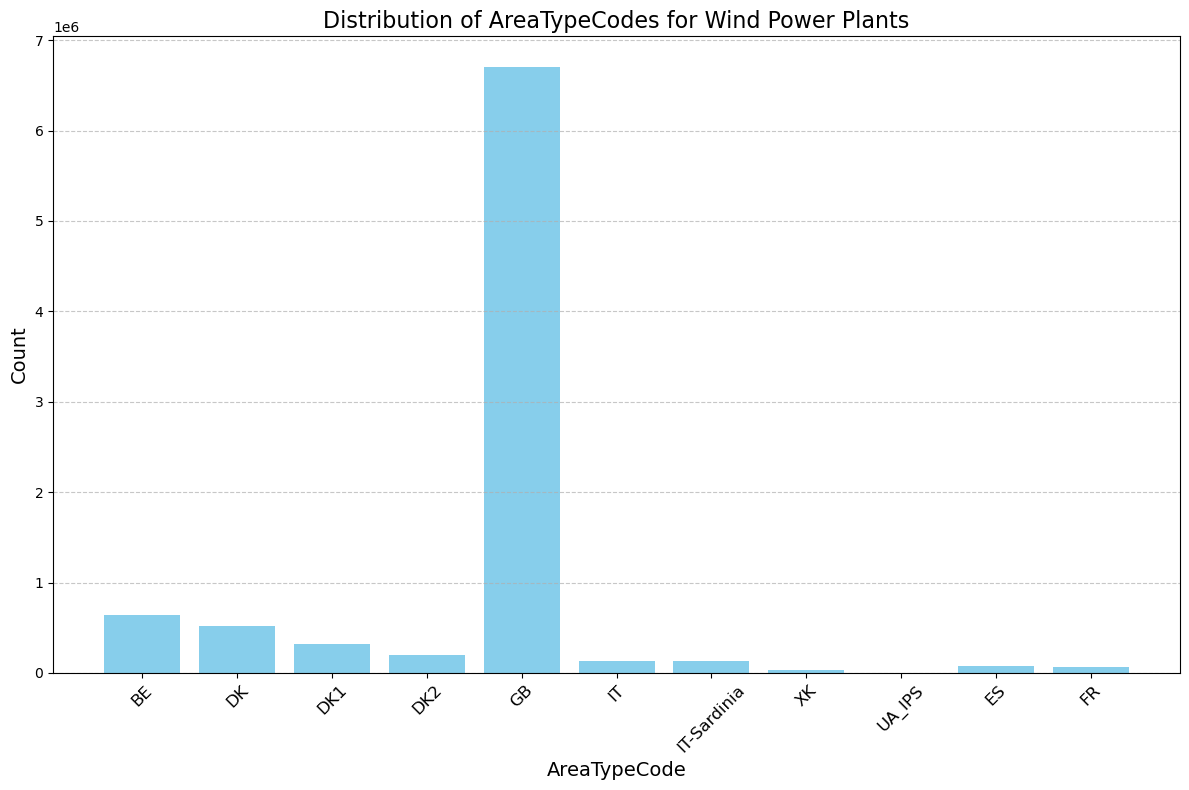

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Basisverzeichnis
input_dir = r"E:\MA_data\raw production history ENTSO-E"

# Liste der Monate von 2015-01 bis 2024-10 generieren
months = pd.date_range(start="2015-01", end="2024-11", freq="MS").strftime("%Y_%m").tolist()

# Dictionary zur Speicherung der AreaTypeCode-Zählung
area_type_counts = {}

# For-Schleife für jede Datei
for month in months:
    # Dateipfad erstellen
    input_file = os.path.join(input_dir, f"{month}_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv")

    # Überprüfen, ob die Datei existiert
    if not os.path.exists(input_file):
        print(f"Datei nicht gefunden: {input_file}")
        continue

    # Datei einlesen
    print(f"Bearbeite Datei: {input_file}")
    data = pd.read_csv(input_file, sep='\t')

    # Filtere nach GenerationUnitType == 'Wind Onshore' oder 'Wind Offshore'
    filtered_data = data[(data['GenerationUnitType'] == 'Wind Onshore ') | (data['GenerationUnitType'] == 'Wind Offshore ')]

    # Zähle die AreaTypeCodes
    for area_code in filtered_data['MapCode']:
        if area_code in area_type_counts:
            area_type_counts[area_code] += 1
        else:
            area_type_counts[area_code] = 1

# Erstellen des Säulendiagramms
area_codes = list(area_type_counts.keys())
counts = list(area_type_counts.values())

plt.figure(figsize=(12, 8))
plt.bar(area_codes, counts, color='skyblue')
plt.xlabel('AreaTypeCode', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of AreaTypeCodes for Wind Power Plants', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

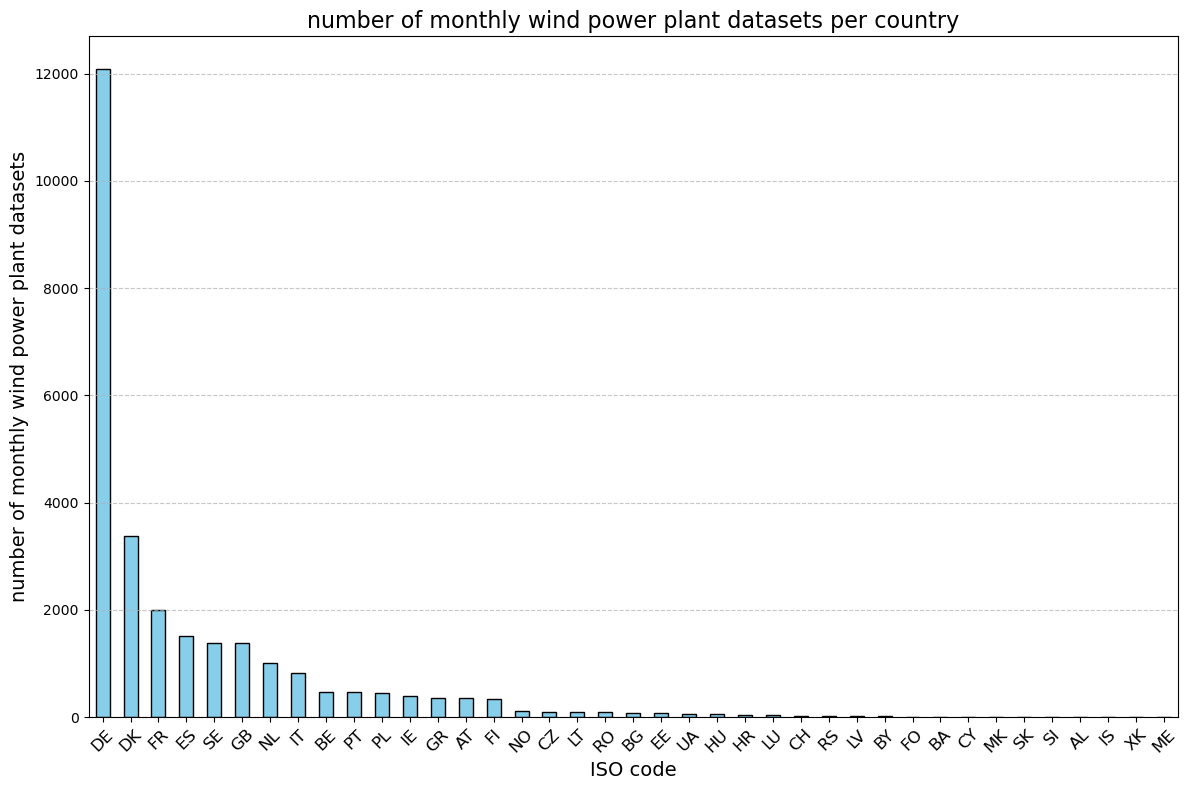

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Datei einlesen
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\WPPs\Windfarms_Europe_20241123.xlsx"
data = pd.read_excel(file_path_excel, sheet_name='Windfarms')
data = data.drop(0) # remove first row (after headlines)

# Zählen der Einträge in der Spalte 'ISO Code'
iso_code_counts = data['ISO code'].value_counts()

# Balkendiagramm erstellen
plt.figure(figsize=(12, 8))
iso_code_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('number of monthly wind power plant datasets per country', fontsize=16)
plt.xlabel('ISO code', fontsize=14)
plt.ylabel('number of monthly wind power plant datasets', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


<h1>Probability distributions ENTSO-E training set and The Wind Power forecasting set

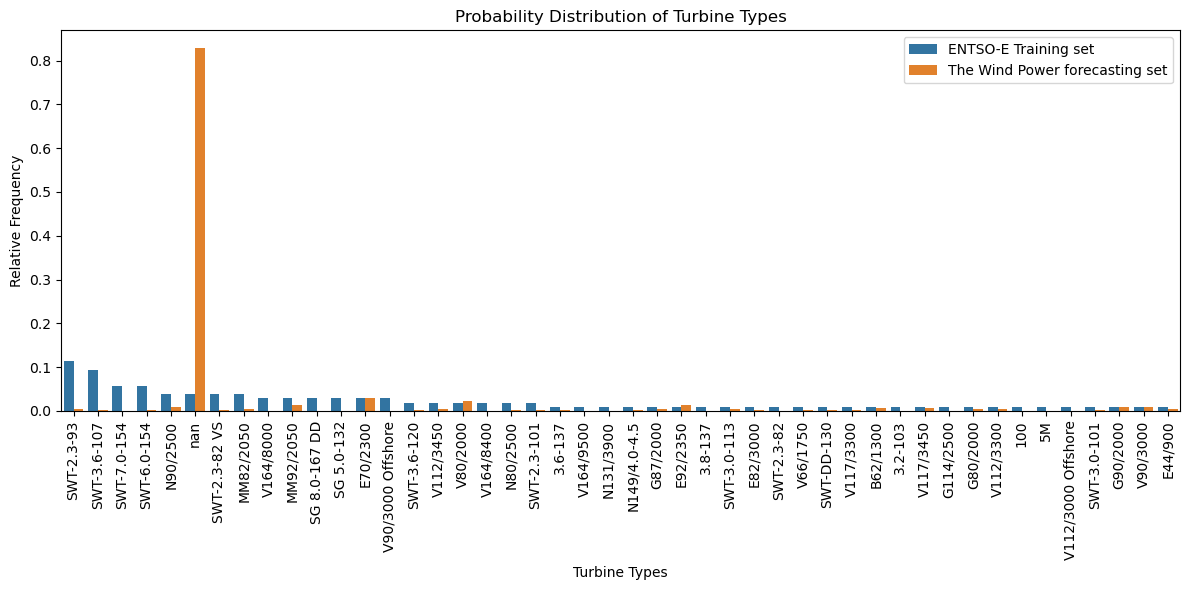

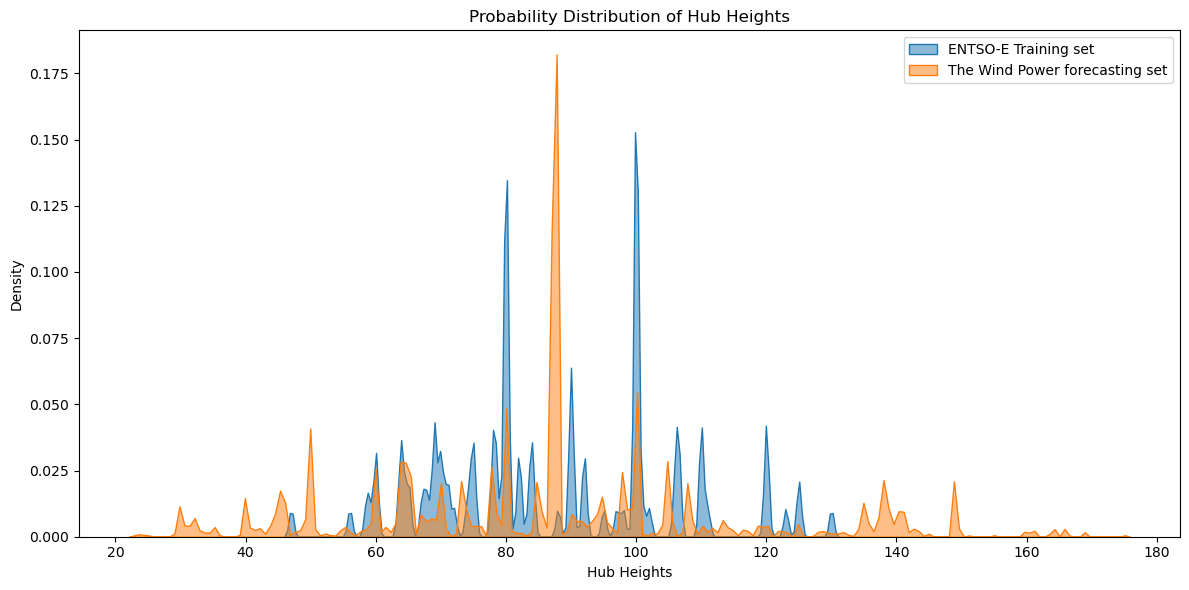

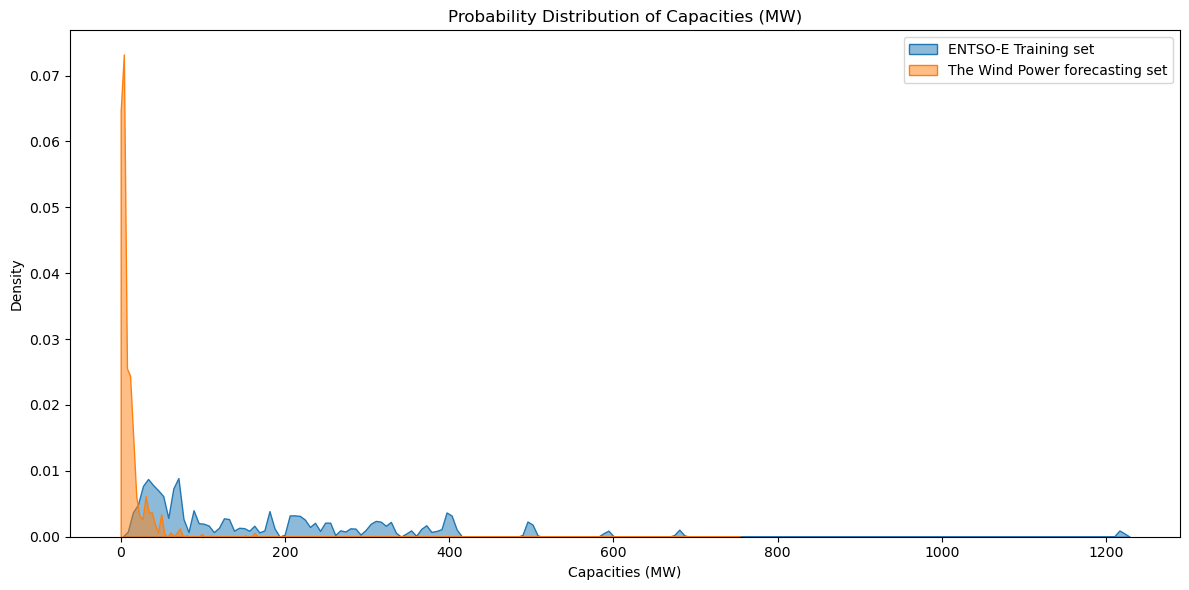

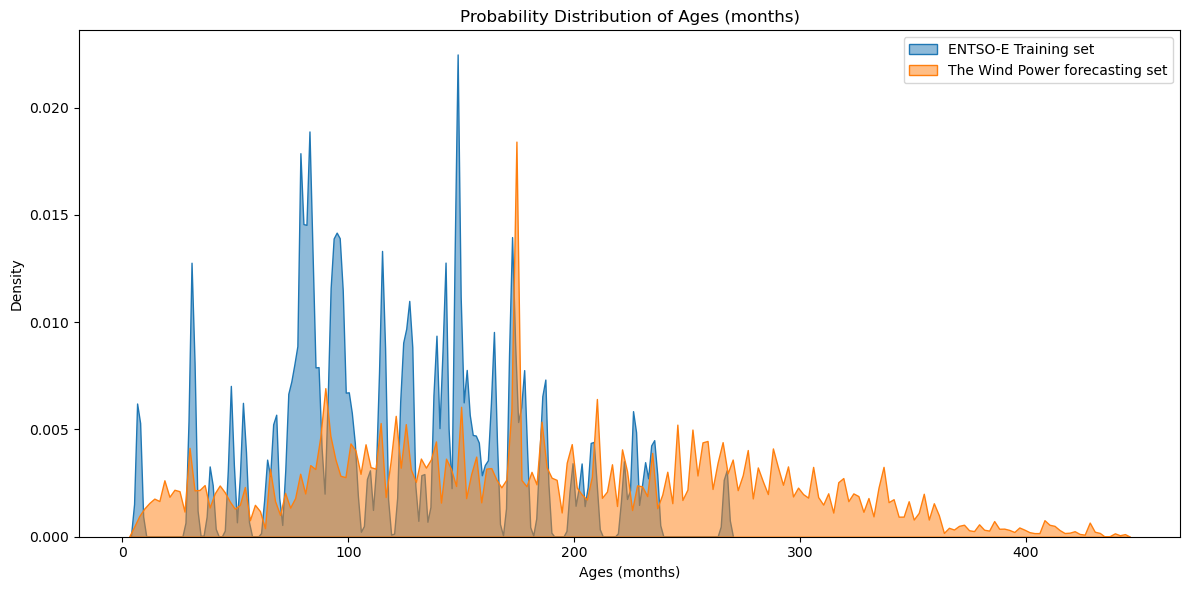

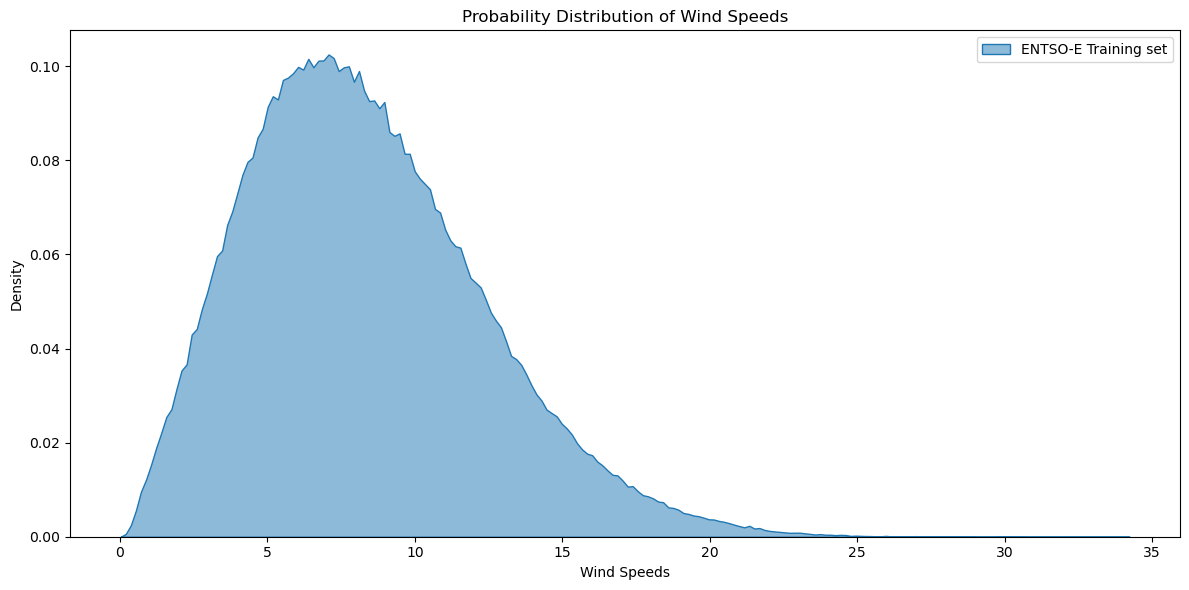

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import OneHotEncoder

# Load WPP + Production Wind JSON data
with open("data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Load The Wind Power data (Parquet)
df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
df = df.iloc[::10]  # Downsampling

# Load turbine type encoder categories
encoder = OneHotEncoder(sparse_output=False)
all_turbine_types = [wpp["Turbine"] if pd.notna(wpp["Turbine"]) else "nan" for wpp in WPP_production_wind]
encoder.fit(np.array(all_turbine_types).reshape(-1, 1))
turbine_categories = encoder.categories_[0]  # 46 categories (with nan as the 46th)

# Create a new "Other/Unknown" category for unmatched turbine types in the second dataset
df["Turbine Category"] = df["Turbine"].apply(lambda x: x if x in turbine_categories else "nan")

# Prepare features for WPP + Production Wind dataset
features_wind = {
    "Turbine Types": [wpp["Turbine"] if pd.notna(wpp["Turbine"]) else "nan" for wpp in WPP_production_wind],
    "Hub Heights": [wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100 for wpp in WPP_production_wind],
    "Capacities (MW)": [wpp["Capacity"] for wpp in WPP_production_wind],
    "Ages (months)": (pd.Timestamp("2024-12-01") - pd.to_datetime(
        ["2015/06" if wpp["Commission_date"] == "nan"
         else f"{wpp['Commission_date']}/06" if isinstance(wpp["Commission_date"], str) and "/" not in wpp["Commission_date"]
         else wpp["Commission_date"] for wpp in WPP_production_wind], format='%Y/%m')).days // 30,
    "Wind Speeds": [entry[2] for wpp in WPP_production_wind for entry in wpp["Production"]]  # Extract wind speeds
}

# Prepare features for The Wind Power dataset
features_twp = {
    "Turbine Types": df["Turbine Category"].values,
    "Hub Heights": df["Hub height"].values,
    "Capacities (MW)": df["Total power"].values / 1e3,  # Convert from kW to MW
    "Ages (months)": df["Ages months"].values,
}

# Plotting function
def plot_feature_distribution(feature_name, data_wind, data_twp=None, is_discrete=False):
    plt.figure(figsize=(12, 6))
    if is_discrete:
        # Normalize frequencies within each dataset
        wind_df = pd.DataFrame({"Source": "ENTSO-E Training set", feature_name: data_wind})
        wind_df = wind_df[feature_name].value_counts(normalize=True).reset_index().rename(columns={"index": feature_name})
        wind_df["Source"] = "ENTSO-E Training set"

        twp_df = pd.DataFrame({"Source": "The Wind Power forecasting set", feature_name: data_twp}) if data_twp is not None else None
        if twp_df is not None:
            twp_df = twp_df[feature_name].value_counts(normalize=True).reset_index().rename(columns={"index": feature_name})
            twp_df["Source"] = "The Wind Power forecasting set"
            # Combine normalized data
            combined_data = pd.concat([wind_df, twp_df]).reset_index(drop=True)
        else:
            combined_data = wind_df

        # Bar plot with "dodge" to display bars side by side
        sns.barplot(data=combined_data, x=feature_name, y="proportion", hue="Source", dodge=True)
        plt.xticks(rotation=90)
        plt.legend(title="Dataset")
    else:
        # KDE plot with reduced smoothing (lower `bw_adjust`)
        sns.kdeplot(data_wind, label="ENTSO-E Training set", fill=True, alpha=0.5, bw_adjust=0.05, clip=(0, None))
        if data_twp is not None:
            sns.kdeplot(data_twp, label="The Wind Power forecasting set", fill=True, alpha=0.5, bw_adjust=0.05, clip=(0, None))
    plt.title(f"Probability Distribution of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Relative Frequency" if is_discrete else "Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot probability distributions
plot_feature_distribution("Turbine Types", features_wind["Turbine Types"], features_twp["Turbine Types"], is_discrete=True)
plot_feature_distribution("Hub Heights", features_wind["Hub Heights"], features_twp["Hub Heights"])
plot_feature_distribution("Capacities (MW)", features_wind["Capacities (MW)"], features_twp["Capacities (MW)"])
plot_feature_distribution("Ages (months)", features_wind["Ages (months)"], features_twp["Ages (months)"])
plot_feature_distribution("Wind Speeds", features_wind["Wind Speeds"])


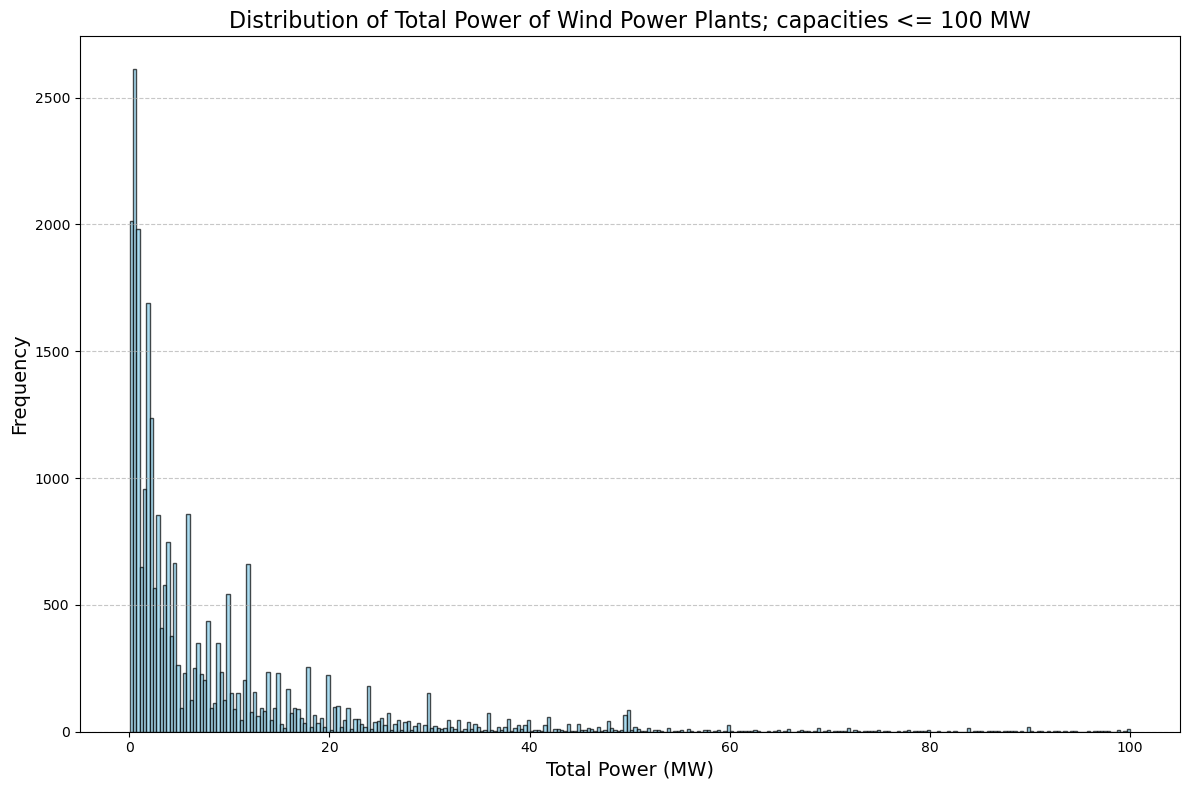

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Datei einlesen
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\WPPs\Windfarms_Europe_20241123.xlsx"
data = pd.read_excel(file_path_excel, sheet_name='Windfarms')
data = data.drop(0)  # Entferne die erste Zeile (nach den Überschriften)

# Spalte 'Total power' einlesen, nicht konvertierbare Werte ignorieren, und in MW umrechnen
data['Total power'] = pd.to_numeric(data['Total power'], errors='coerce')  # Konvertiere zu numerisch, nicht konvertierbare Werte werden NaN
total_power_mw = data['Total power'].dropna() / 1e3
total_power_mw = total_power_mw[(total_power_mw >= 0) & (total_power_mw <= 100)]

# Histogramm erstellen
plt.figure(figsize=(12, 8))
plt.hist(total_power_mw, bins=300, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Power of Wind Power Plants; capacities <= 100 MW', fontsize=16)
plt.xlabel('Total Power (MW)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Diagramm anzeigen
plt.show()